In [54]:
# %matplotlib widget
%matplotlib ipympl
# from ipywidgets import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from scipy.ndimage import gaussian_filter

from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm.notebook import trange, tqdm, tnrange
import time
from datetime import datetime

import math
import glob
import numpy as np


import itertools
import os.path
import os
import sys
from skimage.io import imread
import cv2

import pandas as pd

import imageio
from scipy.signal import savgol_filter
# import pytesseract 

from scipy.signal import find_peaks
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "arial"


import SimpleITK as sitk
import imageio

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [2]:
## Import functions
PathToFunctions = '/Users/iracicot/Documents/GitHub/HySE_HypercubeFunctions/'
sys.path.append(PathToFunctions)
from HySE_HypercubeFunctions import *

## Indicate which wavelengths were used (Panel4, Panel2), in nm

# Wavelengths_list = np.array([566,494,590,518,614,542,638, 578,506,602,530,626,554,650])
# SavingPath = '/Users/iracicot/Library/CloudStorage/OneDrive-UniversityofCambridge/Data/PoM/EndoscopeVideo/20240529/'
# ## Locate the data to analyse
# Name = 'Hand_Moving'
# # Name = 'Flat'
# # Name = 'Columns'



Wavelengths_list = np.array([470,566,494,590,518,614,542,638, 482,578,506,602,530,626,554,650])
SavingPath = '/Users/iracicot/Library/CloudStorage/OneDrive-UniversityofCambridge/Data/PoM/EndoscopeVideo/20240524/'
## Locate the data to analyse
Name = 'Hand'

CropImDimensions = [166,680, 42,520] ## Dazzle, PoM


DataPath = SavingPath
vidPath = DataPath+Name+'.mpg'

Add 'Help=True' in input for a list and description of all optional parameters 
Max plateau size set to 30
Min long dark size set to 50
Expected plateau size set to 17
ATTENTION: ReturnPeaks is set to True. Be careful, the output will have three elements!
Only importing the trace of the data
Cropping Image
Cropping image: x [166 : 680],y [42, 520]
Setting peak height to 0.4
Setting peak distance to 15

[18 21 18 18 18 21 18 25 15 20 19 17 18 21 18 18 18]
  separation: 76 - 17 plateaux, avg 18.88 frames +/- 2.14


[20 18 18 18 21 18 18 18 22 17 18 18 21 18 18 18 21]
  separation: 76 - 17 plateaux, avg 18.82 frames +/- 1.46


[17 18 18 21 18 18 18 21 19 17 18 21 18 18 18 21 18]
  separation: 76 - 17 plateaux, avg 18.65 frames +/- 1.37


[17 18 21 19 17 18 21 18 18 18 21 18 18 18 21 18 18]
  separation: 75 - 17 plateaux, avg 18.65 frames +/- 1.37


[18 21 18 18 18 21 18 18 18 21 18 18 18 21 18 18 18]
  separation: 75 - 17 plateaux, avg 18.71 frames +/- 1.27


[21 18 18 21 21 18 18 18 22 1

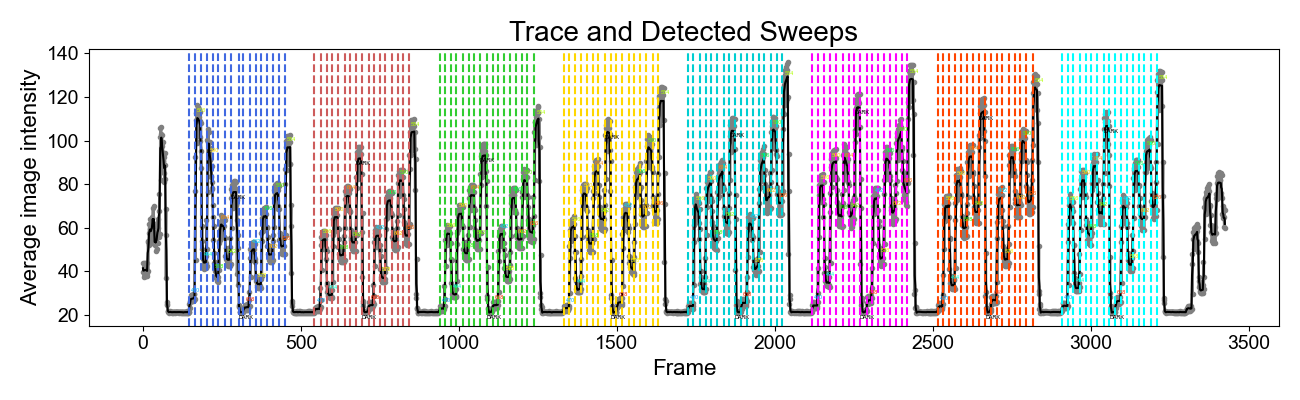

In [3]:
"""

I won't compute the full hypercube, but to help identify where to focus the co-registration,
it will be helpful to identify individual sweeps

Depending on the movement, I can then try to co-registrate individual sweeps
Or co-registrate all of them to be able to then average them together.


"""



## Find the positions of each wavelengths in the data trace
## Start with Help=True to have a list and descriptions of all the
## parameters to play with, and then with PlotGradient=True
## to help optimising

# Help()
## This dataset only has 14 wavelengths because one of the FSKs was off, will need a bit of adjusting

# EdgePos, Peaks, Peaks_dist = FindHypercube(vidPath, Wavelengths_list, PlotGradient=False, CropImDimensions=[166,680, 42,520], DarkMin=180, PlateauSize=35, 
#                                            MaxPlateauSize=60, PeakHeight=1, ReturnPeaks=True, Ncolours=7, PeakDistance=20)

EdgePos, Peaks, Peaks_dist = FindHypercube(vidPath, Wavelengths_list, PlotGradient=False, CropImDimensions=[166,680, 42,520], DarkMin=50, PlateauSize=17, 
                                           MaxPlateauSize=30, PeakHeight=0.4, ReturnPeaks=True, PeakDistance=15, WindowLength=3)


In [134]:
"""

To start, let's consider the first wavelength in the first sweep.
For this we'll need the EdgePos output from the FindHypercube function

Let"s consider the first sweep for simplicity

"""


print(EdgePos[6]) 
print(len(EdgePos[6]))

[[2517   17]
 [2534   18]
 [2552   18]
 [2570   21]
 [2591   18]
 [2609   18]
 [2627   18]
 [2645   21]
 [2666   19]
 [2685   17]
 [2702   18]
 [2720   21]
 [2741   18]
 [2759   18]
 [2777   18]
 [2795   21]
 [2816   18]]
17


In [137]:
"""

I will need to import the data. 


"""

Data = ImportData(vidPath, CropImDimensions=CropImDimensions)
print(Data.shape)

Cropping Image
Cropping image: x [166 : 680],y [42, 520]
(3450, 478, 514)


In [149]:
Nsweep = 7

DataAllC = []

for Nc in range(0,len(EdgePos[Nsweep])):
    Data_c = Data[EdgePos[Nsweep][Nc,0]:EdgePos[Nsweep][Nc,0]+EdgePos[Nsweep][Nc,1], :,:]
    DataAllC.append(Data_c)

## This is what I need to co-register for now

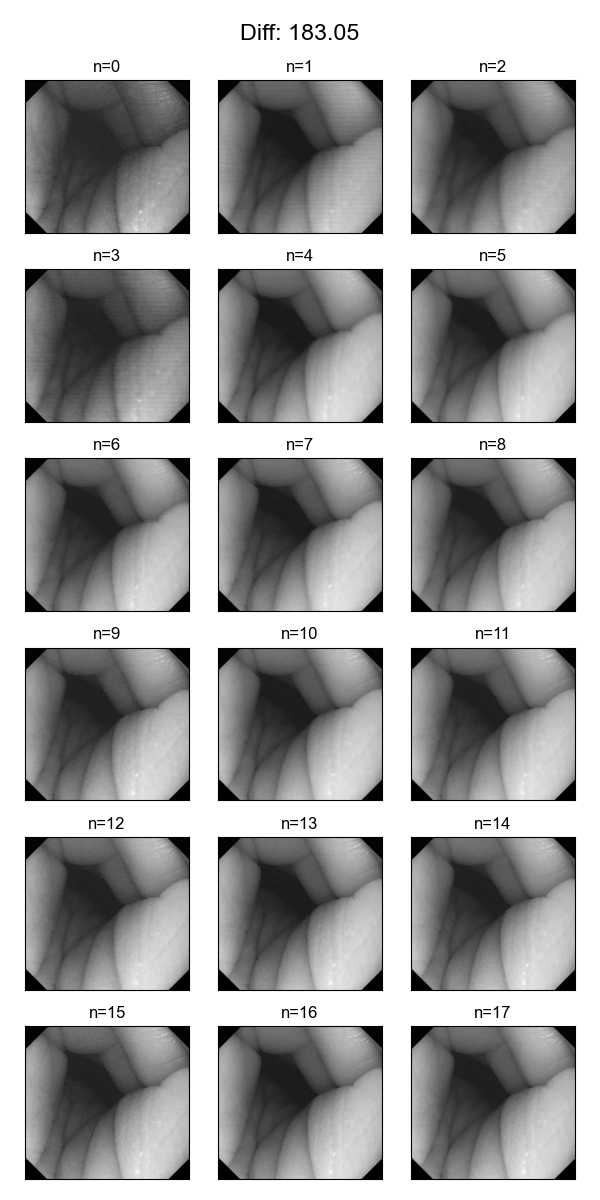

In [152]:
Nx, Ny = 3, 6

Nc = 5

plt.close()
fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(Nx*2,Ny*2))
n = 0
for j in range(0,Ny):
    for i in range(0,Nx):
        try:
            ax[j,i].imshow(DataAllC[Nc][n,:,:], cmap='gray')
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            ax[j,i].set_title(f'n={n}', fontsize=12)
            n += 1
        except IndexError:
            break
diff = np.average(np.subtract(DataAllC[Nc][2,:,:], DataAllC[Nc][-2,:,:]))
plt.suptitle(f'Diff: {diff:.2f}')
plt.tight_layout()
plt.show()

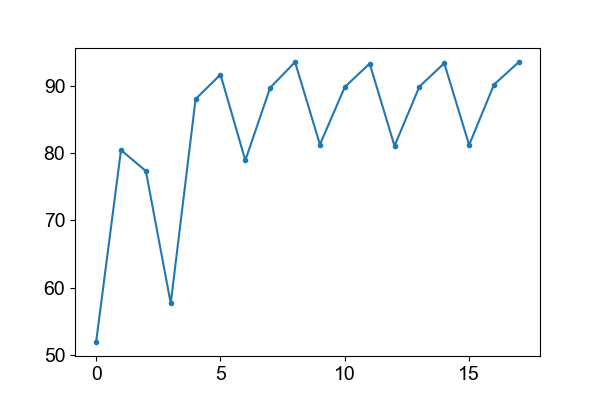

In [153]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.plot(np.average(np.average(DataAllC[5], -1),-1), '.-')
plt.show()

In [218]:
def FindPlottingRange(array):
    array_flat = array.flatten()
    array_sorted = np.sort(array_flat)    
    mean = np.average(array_sorted)
    std = np.std(array_sorted)
    MM = mean+3*std
    mm = mean-3*std
    return mm, MM

def CoRegisterImages(im_static, im_shifted):
    t0 = time.time()
    ## Convert the numpy array to simple elestix format
    im_static_se = sitk.GetImageFromArray(im_static)
    im_shifted_se = sitk.GetImageFromArray(im_shifted)

    ## Create object
    elastixImageFilter = sitk.ElastixImageFilter()
    
    ## Turn off console
    elastixImageFilter.LogToConsoleOff()
    
    ## Set image parameters
    elastixImageFilter.SetFixedImage(im_static_se)
    elastixImageFilter.SetMovingImage(im_shifted_se)
    
    ## Set transform parameters
    parameterMap = sitk.GetDefaultParameterMap('translation')
    parameterMap['Transform'] = ['BSplineTransform']
    ## If required, set maximum number of iterations
#     parameterMap['MaximumNumberOfIterations'] = ['500']
    elastixImageFilter.SetParameterMap(parameterMap)
    
    ## Execute
    result = elastixImageFilter.Execute()
    ## Convert result to numpy array
    im_coregistered = sitk.GetArrayFromImage(result)
    t1 = time.time()
    
    ## Find time taken:
    time_taken = t1-t0
    
    ## return 
    return im_coregistered, time_taken
    
    
def PlotCoRegistered(im_static, im_shifted, im_coregistered, **kwargs):
    """
    
    kwargs: 
        - ShowPlot False(True)
        - SavePlot False(True)
        - SavingPathWithName (default '')
    
    """
    try:
        SavingPathWithName = kwargs['SavingPathWithName']
    except KeyError:
        SavingPathWithName = ''
    
    try:
        SavePlot = kwargs['SavePlot']
    except KeyError:
        SavePlot = False
        
    try:
        ShowPlot = kwargs['ShowPlot']
    except KeyError:
        ShowPlot = False
        
    images_diff_0 = np.subtract(im_shifted.astype('float64'), im_static.astype('float64'))
    images_diff_0_avg = np.average(np.abs(images_diff_0))
#     images_diff_0_std = np.std(np.abs(images_diff_0))
    images_diff_cr = np.subtract(im_coregistered.astype('float64'), im_static.astype('float64'))
    images_diff_cr_avg = np.average(np.abs(images_diff_cr))
#     images_diff_cr_std = np.average(np.std(images_diff_cr))
    
    mmm, MMM = 0, 255
    mm0, MM0 = FindPlottingRange(images_diff_0)
    mm, MM = FindPlottingRange(images_diff_cr)
    
    norm = MidpointNormalize(vmin=mm0, vmax=MM0, midpoint=0)
    cmap = 'RdBu_r'
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,7))
    im00 = ax[0,0].imshow(im_static, cmap='gray',vmin=mmm, vmax=MMM)
    ax[0,0].set_title('Static Image')
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im00, cax=cax, orientation='vertical')

    im01 = ax[0,1].imshow(im_shifted, cmap='gray',vmin=mmm, vmax=MMM)
    ax[0,1].set_title('Shifted Image')
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im01, cax=cax, orientation='vertical')

    im02 = ax[0,2].imshow(images_diff_0, cmap=cmap, norm=norm)
    ax[0,2].set_title(f'Difference (no registration)\n avg {images_diff_0_avg:.2f}')
    divider = make_axes_locatable(ax[0,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im02, cax=cax, orientation='vertical')
    
    im10 = ax[1,0].imshow(im_static, cmap='gray',vmin=mmm, vmax=MMM)
    ax[1,0].set_title('Static Image')
    divider = make_axes_locatable(ax[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im10, cax=cax, orientation='vertical')

    im11 = ax[1,1].imshow(im_coregistered, cmap='gray',vmin=mmm, vmax=MMM)
    ax[1,1].set_title('Coregistered Image')
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im11, cax=cax, orientation='vertical')

    im12 = ax[1,2].imshow(images_diff_cr, cmap=cmap, norm=norm_shift)
    ax[1,2].set_title(f'Difference (with registration)\n avg {images_diff_cr_avg:.2f}')
    divider = make_axes_locatable(ax[1,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im12, cax=cax, orientation='vertical')

    ## Add grid to help see changes in images
    (YY, XX) = im_static.shape
    xm, ym = int(XX/2), int(YY/2)
    xmm, ymm = int(xm/2), int(ym/2)
    x_points = [xmm, xm, xm+xmm, 3*xmm]
    y_points = [ymm, ym, ym+ymm, 3*ymm]
    for i in range(0,3):
        for j in range(0,2):
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            for k in range(0,4):
                ax[j,i].axvline(x_points[k], c='limegreen', ls='dotted')
                ax[j,i].axhline(y_points[k], c='limegreen', ls='dotted')

    plt.tight_layout()
    if SavePlot:
        print(f'Saving figure @ {SavingPathWithName}')
        print(f'   Set SavingPathWithName=\'path\' to set saving path')
        plt.savefig(f'{SavingPathWithName}_CoRegistration.png')
    if ShowPlot:
        plt.show()
    else:
        plt.close()

    

Saving figure @ 
   Set SavingPathWithName='path' to set saving path


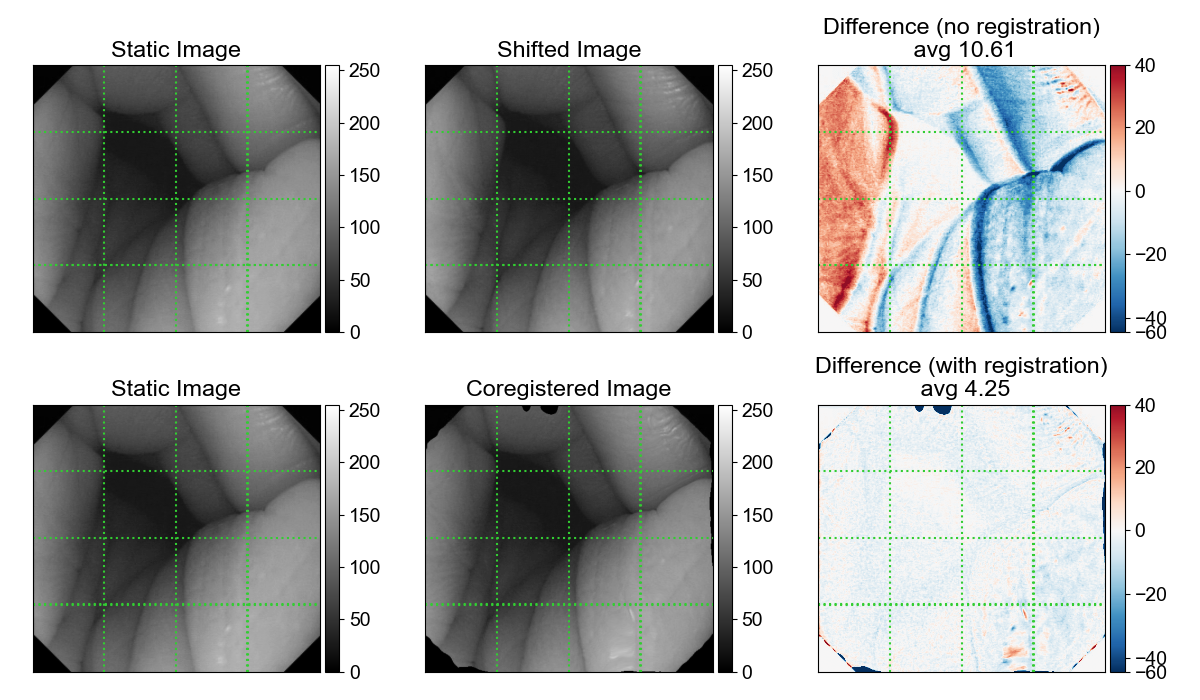

In [219]:
n0 = 8
n = 14
im_static = DataAllC[Nc][n0,:,:]
im_shifted = DataAllC[Nc+7][n,:,:]


im_coregistered, time_taken = CoRegisterImages(im_static, im_shifted)
# PlotCoRegistered(im_static, im_shifted, im_coregistered, ShowPlot=True, SavePlot=True)

In [197]:
# n0 = 8
# n = 14
# im_static = DataAllC[Nc][n0,:,:]
# # im_shifted = DataAllC[Nc][n,:,:]
# im_shifted = DataAllC[Nc+7][n,:,:]

# t0 = time.time()
# im_static_se = sitk.GetImageFromArray(im_static)
# im_shifted_se = sitk.GetImageFromArray(im_shifted)

# elastixImageFilter = sitk.ElastixImageFilter()
# elastixImageFilter.LogToConsoleOff()

# elastixImageFilter.SetFixedImage(im_static_se)
# elastixImageFilter.SetMovingImage(im_shifted_se)

# # elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("rigid"))

# # parameterMap = sitk.GetDefaultParameterMap('affine')
# parameterMap = sitk.GetDefaultParameterMap('rigid')

# # parameterMap = sitk.GetDefaultParameterMap('translation')
# # parameterMap['Transform'] = ['BSplineTransform']

# # parameterMap['MaximumNumberOfIterations'] = ['500']

# elastixImageFilter.SetParameterMap(parameterMap)


# result = elastixImageFilter.Execute()
# im_coregistered = sitk.GetArrayFromImage(result)
# t1 = time.time()
# print(f'It took {t1-t0:.2f} s to co-register the image')

In [198]:
# mmm, MMM = 0, 255


# images_diff = np.subtract(im_shifted.astype('float64'), im_static.astype('float64'))
# mm, MM = FindPlottingRange(images_diff)

# norm = MidpointNormalize(vmin=mm, vmax=MM, midpoint=0)
# cmap = 'RdBu_r' 

# plt.close()
# fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,7))
# im00 = ax[0,0].imshow(im_static, cmap='gray',vmin=mmm, vmax=MMM) #,vmin=20, vmax=60
# ax[0,0].set_title('im_static')
# divider = make_axes_locatable(ax[0,0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im00, cax=cax, orientation='vertical')

# im01 = ax[0,1].imshow(im_shifted, cmap='gray',vmin=mmm, vmax=MMM)
# ax[0,1].set_title('im_shifted')
# divider = make_axes_locatable(ax[0,1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im01, cax=cax, orientation='vertical')

# im02 = ax[0,2].imshow(images_diff, cmap=cmap, norm=norm)
# ax[0,2].set_title('Difference (no registration)')
# divider = make_axes_locatable(ax[0,2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im02, cax=cax, orientation='vertical')


# images_shift_diff = np.subtract(im_coregistered.astype('float64'), im_static.astype('float64'))
# norm_shift = norm

# im10 = ax[1,0].imshow(im_static, cmap='gray',vmin=mmm, vmax=MMM) #,vmin=20, vmax=60
# ax[1,0].set_title('im_static')
# divider = make_axes_locatable(ax[1,0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im10, cax=cax, orientation='vertical')

# im11 = ax[1,1].imshow(im_coregistered, cmap='gray',vmin=mmm, vmax=MMM)
# ax[1,1].set_title('im_coregistered')
# divider = make_axes_locatable(ax[1,1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im11, cax=cax, orientation='vertical')

# im12 = ax[1,2].imshow(images_shift_diff, cmap=cmap, norm=norm_shift)
# ax[1,2].set_title('Difference (with registration)')
# divider = make_axes_locatable(ax[1,2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(im12, cax=cax, orientation='vertical')

# (YY, XX) = im_static.shape
# xm = int(XX/2)
# xmm = int(xm/2)
# ym = int(YY/2)
# ymm = int(ym/2)
# x_points = [xmm, xm, xm+xmm, 3*xmm]
# y_points = [ymm, ym, ym+ymm, 3*ymm]
# for i in range(0,3):
#     for j in range(0,2):
#         ax[j,i].set_xticks([])
#         ax[j,i].set_yticks([])
#         for k in range(0,4):
#             ax[j,i].axvline(x_points[k], c='limegreen', ls='dotted')
#             ax[j,i].axhline(y_points[k], c='limegreen', ls='dotted')

# plt.tight_layout()
# # plt.savefig(f'{SavingPath}{Name}.png')
# plt.show()